In [1]:
import time
import random
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from ast import literal_eval
from tqdm.notebook import tqdm
from utility.utility import ndcg, mAP_score, highlight, history_plot, generate_pairwise_dataset

pd.options.mode.chained_assignment = None
tqdm.pandas()
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 50)
%matplotlib inline

C:\Users\kwon\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
class Conv_stack(tf.keras.layers.Layer):
    def __init__(self, lg, nf):
        super(Conv_stack, self).__init__(name='ConV_stack')
        self.lg = lg
        self.nf = nf
        self.conv_dict = {}
        for i in range(2, self.lg+1):
            self.conv_dict[i] = tf.keras.layers.Conv2D(self.nf, i, strides=(1, 1), padding='same')

    def call(self, inputs):
        if len(inputs.shape) == 3:
            inputs = tf.expand_dims(inputs, axis=-1)
        else:
            inputs = tf.transpose(inputs, [0, 2, 3, 1])
        x_1 = inputs
        x = {}
        for i in range(2, self.lg+1):
            x[i] = self.conv_dict[i](inputs)
        return tf.keras.layers.concatenate([x_1] + [x[k] for k in x]) 

In [3]:
class Dim_wise_max_pooling(tf.keras.layers.Layer):
    def __init__(self, lg, nf):
        super(Dim_wise_max_pooling, self).__init__(name='dim_wise_max_pooling')
        self.lg = lg
        self.nf = nf
        
    def call(self, inputs):
        inputs_channel_num = inputs.shape[-1] + (1 - self.lg)*self.nf
        channel_range = [0] + [self.nf*i+inputs_channel_num for i in range(self.lg)]
        x = {}
        for i in range(1, self.lg+1):
            x[i] = tf.math.reduce_max(inputs[:, :, :, channel_range[i-1]:channel_range[i]], axis=-1, keepdims=True)
            
        return tf.keras.layers.concatenate([x[k] for k in x])

In [4]:
class Row_wise_max_pooling(tf.keras.layers.Layer):
    def __init__(self, ns, lg):
        super(Row_wise_max_pooling, self).__init__(name='row_wise_max_pooling')
        self.ns = ns
        self.lg = lg
        
    def call(self, inputs):
        x = {}
        for i in range(1, self.lg+1):
            x[i] = tf.math.top_k(inputs[:, :, :, i-1], k=self.ns)[0]
            
        return tf.keras.layers.concatenate([x[k] for k in x])

In [5]:
class Idf_concat(tf.keras.layers.Layer):
    def __init__(self):
        super(Idf_concat, self).__init__(name='idf_concat')
        
    def call(self, inputs, idf):
        expand_idf = tf.expand_dims(idf, axis=-1)
        return tf.keras.layers.concatenate([inputs, expand_idf])

In [6]:
class Recurrent_Layer(tf.keras.layers.Layer):
    def __init__(self, lq, ns, lg):
        super(Recurrent_Layer, self).__init__(name='Recurrent_Layer')
        self.inputs_shape = (None, lq, ns*lg+1)
        self.lstm = tf.keras.layers.LSTM(units=1, input_shape=self.inputs_shape)
        
    def call(self, inputs):
        return self.lstm(inputs)

In [7]:
class PACRR(tf.keras.layers.Layer):
    def __init__(self, lq, lg, nf, ns):
        super(PACRR, self).__init__(name='PACRR')
        self.lq = lq
        self.lg = lg
        self.nf = nf
        self.ns = ns
        
        self.conv_stack = Conv_stack(lg=self.lg, nf=self.nf)
        self.BN = tf.keras.layers.BatchNormalization()
        self.dim_wise_max_pooling = Dim_wise_max_pooling(lg=self.lg, nf=self.nf)
        self.row_wise_max_pooling = Row_wise_max_pooling(lg=self.lg, ns=self.ns)
        self.idf_concat = Idf_concat()
        self.recurrent_Layer = Recurrent_Layer(lq=self.lq, ns=self.ns, lg=self.lg)

    def call(self, inputs, idf):
        x = self.conv_stack(inputs)
        x = self.dim_wise_max_pooling(x)
        x = self.row_wise_max_pooling(x)
        x = self.idf_concat(x, idf)
        x = self.recurrent_Layer(x)
        return x

In [8]:
class Pairwise_PACRR(tf.keras.Model):
    def __init__(self, lq, lg, nf, ns):
        super(Pairwise_PACRR, self).__init__(name='Pairwise_PACRR')
        self.Pacrr = PACRR(lq, lg, nf, ns)
        
    def call(self, inputs):
        positive_sim = inputs['positive_sim_matrix']
        negative_sim = inputs['negative_sim_matrix']
        idf = inputs['idf_softmax']
        
        positive = self.Pacrr(positive_sim, idf)
        negative = self.Pacrr(negative_sim, idf)
        
        return tf.concat([positive, negative], axis=0) 

In [14]:
# # bert
# test = pd.read_csv('./data/paccr_drmm_bert_test_all.csv', converters={"query_idf": literal_eval,
#                                                                       "idf_softmax": literal_eval,
#                                                                       "sim_matrix": literal_eval,
#                                                                       "query_token": literal_eval,
#                                                                       "product_title_token": literal_eval,
#                                                                       "token_ids": literal_eval,
#                                                                       "drmm_hist": literal_eval,
#                                                                       'token': literal_eval})

# test['binary_relevance'] = test['median_relevance'].apply(lambda x: 0 if x <= 2 else 1)

# df = generate_pairwise_dataset(test)
# df.reset_index(inplace=True, drop=True)

# dev_q = set(random.sample(list(df['query'].unique()), 45))
# train_q = set(df['query'].unique()) - dev_q

# train = pd.concat([df.groupby('query').get_group(name) for name in train_q]).sample(frac=1).reset_index(drop=True)
# dev = pd.concat([df.groupby('query').get_group(name) for name in dev_q]).sample(frac=1).reset_index(drop=True)

# metadata = {'negative_sim_matrix': tf.constant(train['sim_matrix_N'].tolist(), dtype=tf.float32), 
#             'positive_sim_matrix': tf.constant(train['sim_matrix_P'].tolist(), dtype=tf.float32),
#             'idf_softmax': tf.constant(train['idf_softmax'].tolist(), dtype=tf.float32)}

# metadata_dev ={'negative_sim_matrix': tf.constant(dev['sim_matrix_N'].tolist(), dtype=tf.float32), 
#             'positive_sim_matrix': tf.constant(dev['sim_matrix_P'].tolist(), dtype=tf.float32),
#             'idf_softmax': tf.constant(dev['idf_softmax'].tolist(), dtype=tf.float32)}

# firstk = 13
# lq = 8

In [43]:
# word2vec
df = pd.read_csv('./data/paccr_drmm_.csv', converters={"negative_sim_matrix": literal_eval,
                                                      "positive_sim_matrix": literal_eval,
                                                      "idf_softmax": literal_eval})
df = df[['query_preprocessed', 'negative_sim_matrix', 'positive_sim_matrix', 'idf_softmax']]

test = pd.read_csv('./data/paccr_drmm_test.csv', converters={"hist": literal_eval,
                                                             "query_idf": literal_eval,
                                                             "sim_matrix": literal_eval,
                                                             "idf_softmax": literal_eval})

dev_q = set(random.sample(list(df['query_preprocessed'].unique()), 45))
train_q = set(df['query_preprocessed'].unique()) - dev_q

train = pd.concat([df.groupby('query_preprocessed').get_group(name) for name in train_q]).sample(frac=1).reset_index(drop=True)
dev = pd.concat([df.groupby('query_preprocessed').get_group(name) for name in dev_q]).sample(frac=1).reset_index(drop=True)

metadata = {'negative_sim_matrix': tf.constant(train['negative_sim_matrix'].tolist(), dtype=tf.float32), 
            'positive_sim_matrix': tf.constant(train['positive_sim_matrix'].tolist(), dtype=tf.float32),
            'idf_softmax': tf.constant(train['idf_softmax'].tolist(), dtype=tf.float32)}

metadata_dev ={'negative_sim_matrix': tf.constant(dev['negative_sim_matrix'].tolist(), dtype=tf.float32), 
            'positive_sim_matrix': tf.constant(dev['positive_sim_matrix'].tolist(), dtype=tf.float32),
            'idf_softmax': tf.constant(dev['idf_softmax'].tolist(), dtype=tf.float32)}

firstk = 8
lq = 6

In [22]:
ds = tf.data.Dataset.from_tensor_slices(metadata)
ds = ds.shuffle(buffer_size=len(train))
batchs = 128
ds = ds.batch(batchs).repeat()
example_batch = next(iter(ds))

lg = 5
nf = 32
ns = 2

In [24]:
print_step = 100
n = 20
learning_rate = .1
lg = 5
nf = 32
ns = 2

tf.keras.backend.clear_session()
model = Pairwise_PACRR(lq, lg, nf, ns)
optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)

Pairwise_ranking_loss(y_true=None, y_pred=model(example_batch))

<tf.Tensor: shape=(), dtype=float32, numpy=1.0013853>

In [ ]:
loss_sum = 0
ndcg_sum = 0
mAP_sum = 0

step_history = []
loss_history = []
loss_history_dev = []
ndcg_history = []
mAP_history = []

for step, batch_train in enumerate(ds):
    
    with tf.GradientTape() as tape:
        logits = model(batch_train)
        loss_value = Pairwise_ranking_loss(y_true=None, y_pred=logits)
        loss_sum += loss_value 
        
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    if step % print_step == 0:
        current_loss_average = float(loss_sum)/print_step
        if step ==0:
            current_loss_average = loss_sum

        logits_dev = model(metadata_dev)
        current_loss_average_dev = Pairwise_ranking_loss(y_true=None, y_pred=logits_dev)
        
        for q in dev_q:
#             ndcg_test = test[test['query_preprocessed'] == q]
            ndcg_test = test[test['query'] == q]
            metadata_ndcg = {'sim_matrix': tf.constant(ndcg_test['sim_matrix'].tolist(), dtype=tf.float32), 
                             'idf_softmax': tf.constant(ndcg_test['idf_softmax'].tolist(), dtype=tf.float32)}
            
            ndcg_test['rel'] = model.predict(metadata_ndcg).numpy()
            ndcg_sum += ndcg(list(ndcg_test.sort_values(by=['rel'], axis=0, ascending=False)['median_relevance']-1), p=n, form="exp")
            mAP_sum += mAP_score(list(ndcg_test.sort_values(by=['rel'], axis=0, ascending=False)['binary_relevance']))
            
        current_ndcg_average = ndcg_sum/len(dev_q)
        current_mAP_average = mAP_sum/len(dev_q)
        
        step_history.append(step)
        loss_history.append(current_loss_average)
        loss_history_dev.append(current_loss_average_dev)
        ndcg_history.append(current_ndcg_average)
        mAP_history.append(current_mAP_average)
        
        print("Training loss at step %d: %.5f, dev_loss : %.5f, nDCG@20 : %.5f, mAP : %.5f"% (step, 
                                                                                              current_loss_average, 
                                                                                              current_loss_average_dev,
                                                                                              current_ndcg_average,
                                                                                              current_mAP_average))
        
        print("Seen so far: %s train samples, learning rate: %.4f" % ((step + 1) * batchs, learning_rate))
        ndcg_sum = 0
        loss_sum = 0
        mAP_sum = 0
        
    if step == 600:
        break

Training loss at step 0: 1.00037, dev_loss : 0.99966, nDCG@20 : 0.72494, mAP : 0.74735
Seen so far: 128 train samples, learning rate: 0.1000
Training loss at step 10: 0.99910, dev_loss : 0.99652, nDCG@20 : 0.81998, mAP : 0.83156
Seen so far: 1408 train samples, learning rate: 0.1000
Training loss at step 20: 0.99780, dev_loss : 0.99472, nDCG@20 : 0.83444, mAP : 0.85025
Seen so far: 2688 train samples, learning rate: 0.1000
Training loss at step 30: 0.99588, dev_loss : 0.99306, nDCG@20 : 0.84093, mAP : 0.85466
Seen so far: 3968 train samples, learning rate: 0.1000
Training loss at step 40: 0.99469, dev_loss : 0.99096, nDCG@20 : 0.84528, mAP : 0.85829
Seen so far: 5248 train samples, learning rate: 0.1000
Training loss at step 50: 0.99422, dev_loss : 0.98874, nDCG@20 : 0.84515, mAP : 0.85905
Seen so far: 6528 train samples, learning rate: 0.1000
Training loss at step 60: 0.99127, dev_loss : 0.98547, nDCG@20 : 0.83814, mAP : 0.85458
Seen so far: 7808 train samples, learning rate: 0.1000
T

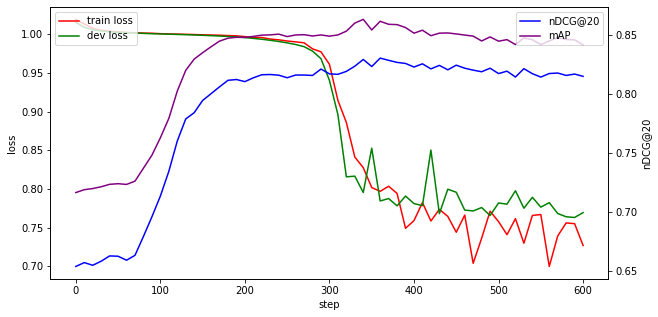

In [416]:
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('step')
ax1.set_ylabel('loss')
ax1.plot(step_history, loss_history, color='r', label='train loss')
ax1.plot(step_history, loss_history_dev, color='g', label='dev loss')
# ax1.set_ylim(0.8, 1.1)
ax1.legend(loc=2)


ax2 = ax1.twinx() 

ax2.set_ylabel('nDCG@20')  
ax2.plot(step_history, ndcg_history, color='b', label='nDCG@20')
ax2.plot(step_history, mAP_history, color='purple', label='mAP')

ax2.legend(loc=1)
plt.show()